# Self driving demo -- pytorch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random
import warnings

In [3]:
dir = "D:/Games/beta_simulator_windows/dataset"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(dir, "driving_log.csv"), names=columns)
# pd.set_option("display.max_colwidth", -1)
data.head()

center  \
0  D:\Games\beta_simulator_windows\dataset\IMG\ce...   
1  D:\Games\beta_simulator_windows\dataset\IMG\ce...   
2  D:\Games\beta_simulator_windows\dataset\IMG\ce...   
3  D:\Games\beta_simulator_windows\dataset\IMG\ce...   
4  D:\Games\beta_simulator_windows\dataset\IMG\ce...   

                                                left  \
0  D:\Games\beta_simulator_windows\dataset\IMG\le...   
1  D:\Games\beta_simulator_windows\dataset\IMG\le...   
2  D:\Games\beta_simulator_windows\dataset\IMG\le...   
3  D:\Games\beta_simulator_windows\dataset\IMG\le...   
4  D:\Games\beta_simulator_windows\dataset\IMG\le...   

                                               right  steering  throttle  \
0  D:\Games\beta_simulator_windows\dataset\IMG\ri...       0.0       0.0   
1  D:\Games\beta_simulator_windows\dataset\IMG\ri...       0.0       0.0   
2  D:\Games\beta_simulator_windows\dataset\IMG\ri...       0.0       0.0   
3  D:\Games\beta_simulator_windows\dataset\IMG\ri...       0.0       0.0   
4  D:\Games\beta_simulator_windows\dataset\IMG\ri...       0.0       0.0   

   reverse     speed  
0        0  27.18536  
1        0  27.02019  
2        0  26.80151  
3        0  26.63866  
4        0  26.42305

In [4]:
def pathleaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].apply(pathleaf)
data["right"] = data["right"].apply(pathleaf)
data.head()

center                              left  \
0  center_2026_02_14_16_20_36_769.jpg  left_2026_02_14_16_20_36_769.jpg   
1  center_2026_02_14_16_20_36_835.jpg  left_2026_02_14_16_20_36_835.jpg   
2  center_2026_02_14_16_20_36_904.jpg  left_2026_02_14_16_20_36_904.jpg   
3  center_2026_02_14_16_20_36_973.jpg  left_2026_02_14_16_20_36_973.jpg   
4  center_2026_02_14_16_20_37_045.jpg  left_2026_02_14_16_20_37_045.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2026_02_14_16_20_36_769.jpg       0.0       0.0        0  27.18536  
1  right_2026_02_14_16_20_36_835.jpg       0.0       0.0        0  27.02019  
2  right_2026_02_14_16_20_36_904.jpg       0.0       0.0        0  26.80151  
3  right_2026_02_14_16_20_36_973.jpg       0.0       0.0        0  26.63866  
4  right_2026_02_14_16_20_37_045.jpg       0.0       0.0        0  26.42305

In [5]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


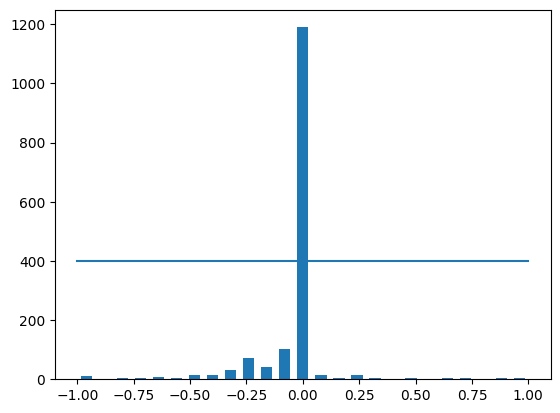

In [6]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [7]:
print("Total Data:", len(data))

Total Data: 1568


In [8]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print("Removed:", len(remove_list))

Removed: 790


In [9]:
data.drop(data.index[remove_list], inplace=True)
print("Remaining:", len(data))

Remaining: 778


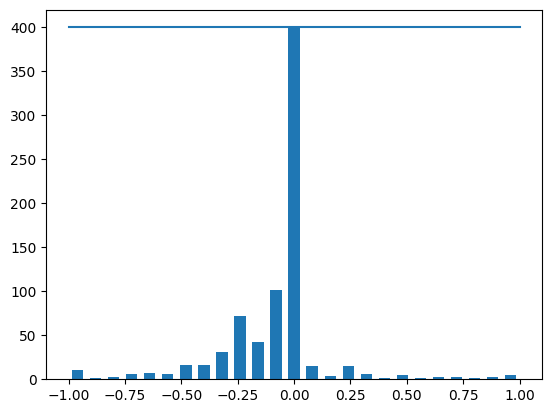

In [10]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [11]:
print(data.iloc[1])

center      center_2026_02_14_16_20_37_110.jpg
left          left_2026_02_14_16_20_37_110.jpg
right        right_2026_02_14_16_20_37_110.jpg
steering                                   0.0
throttle                                   0.0
reverse                                      0
speed                                 26.26249
Name: 5, dtype: object


In [15]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15) # left image need to automatic turn right
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15) # and right image need to turn left
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [13]:
image_paths, steerings = load_img_steering(dir + "/IMG", data)
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 1867
Valid Samples: 467


C:\Users\74267\AppData\Local\Temp\ipykernel_124228\961603952.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
C:\Users\74267\AppData\Local\Temp\ipykernel_124228\961603952.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
C:\Users\74267\AppData\Local\Temp\ipykernel_124228\961603952.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

Text(0.5, 1.0, 'Validation set')

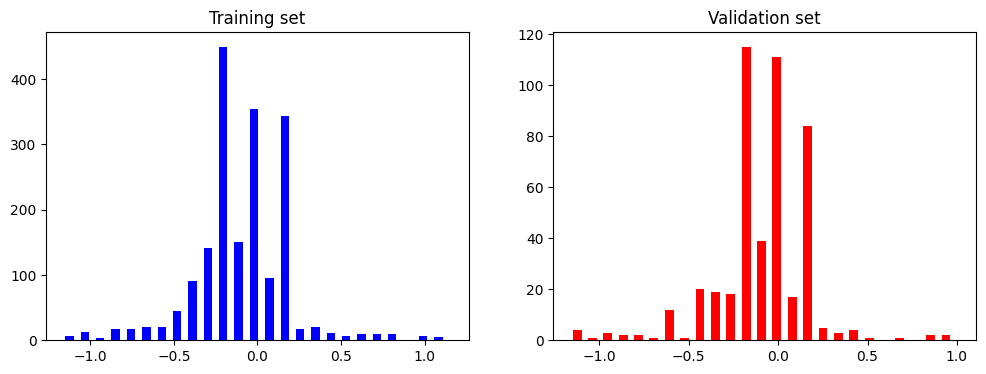

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation set")

Text(0.5, 1.0, 'Zoomed Image')

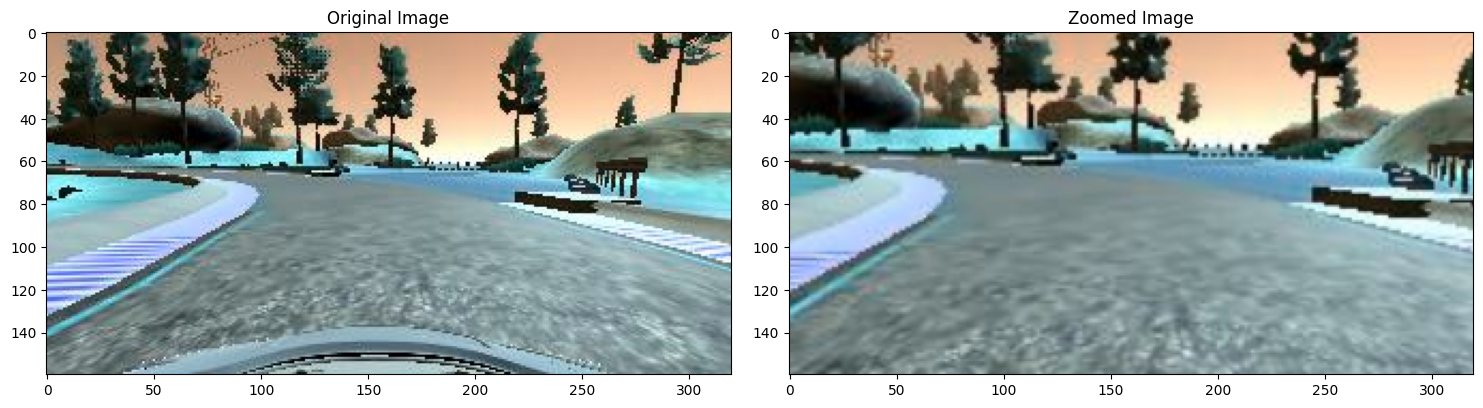

In [23]:
def zoom(img, center=None):
    zoom_factor = 0.7 # zoom in factor
    
    h, w = img.shape[:2]
    
    # 计算缩放后的尺寸
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    
    # 确定裁剪区域
    if center is None:
        center = (w // 2, h // 2)
    
    # 计算裁剪区域
    crop_x1 = max(0, center[0] - new_w // 2)
    crop_y1 = max(0, center[1] - new_h // 2)
    crop_x2 = min(w, crop_x1 + new_w)
    crop_y2 = min(h, crop_y1 + new_h)
    
    # 裁剪并缩放
    cropped = img[crop_y1:crop_y2, crop_x1:crop_x2]
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    
    return zoomed

image = image_paths[random.randint(0, 1000)]
original_image = cv2.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.15')

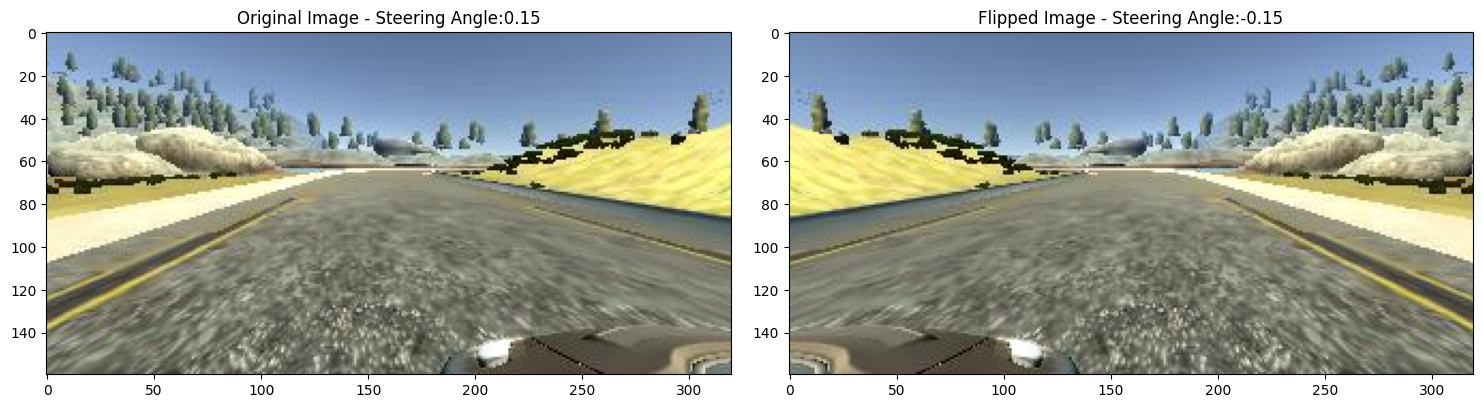

In [24]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle:" + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image - " + "Steering Angle:" + str(flipped_steering_angle))

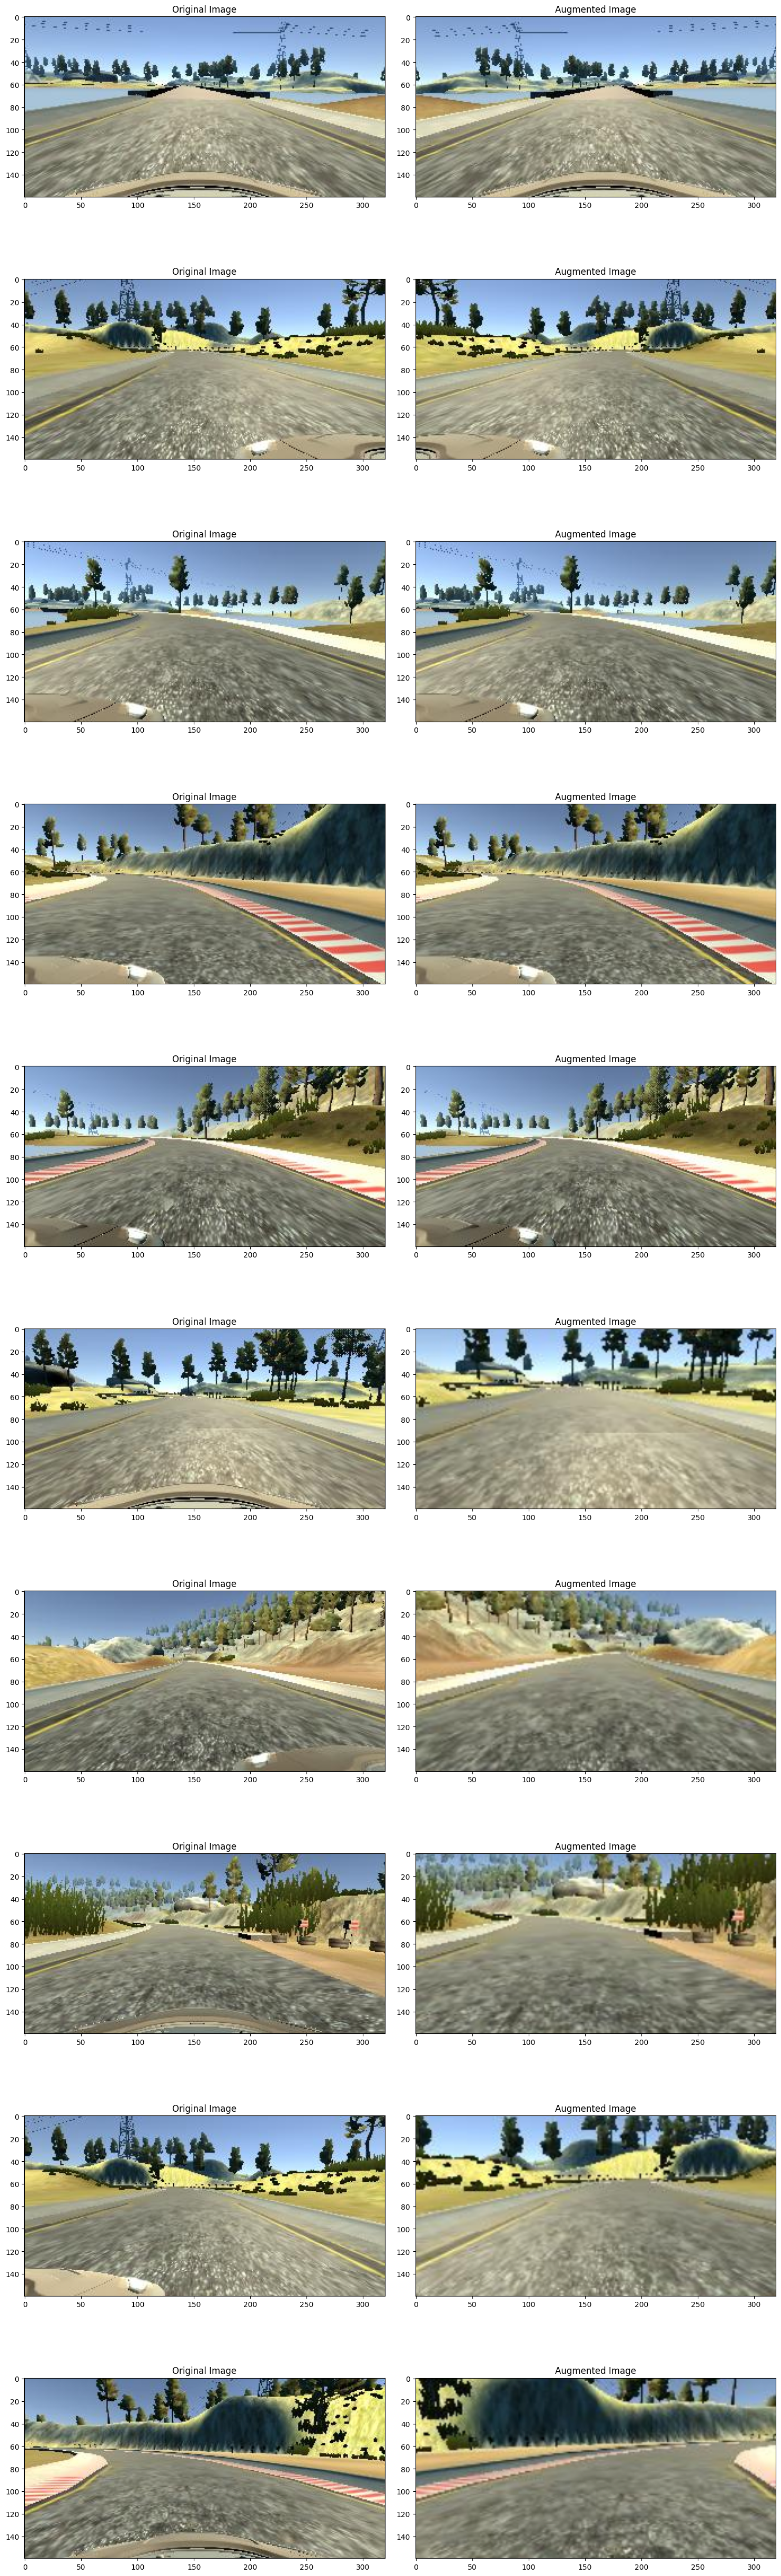

In [27]:
def random_augment(image_path, steering_angle):
    image = mpimg.imread(image_path)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [28]:
def img_preprocess(img):
    ## Crop image to remove unnecessary features
    img = img[60:135, :, :]
    ## Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    ## Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ## Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    ## Normalize values
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

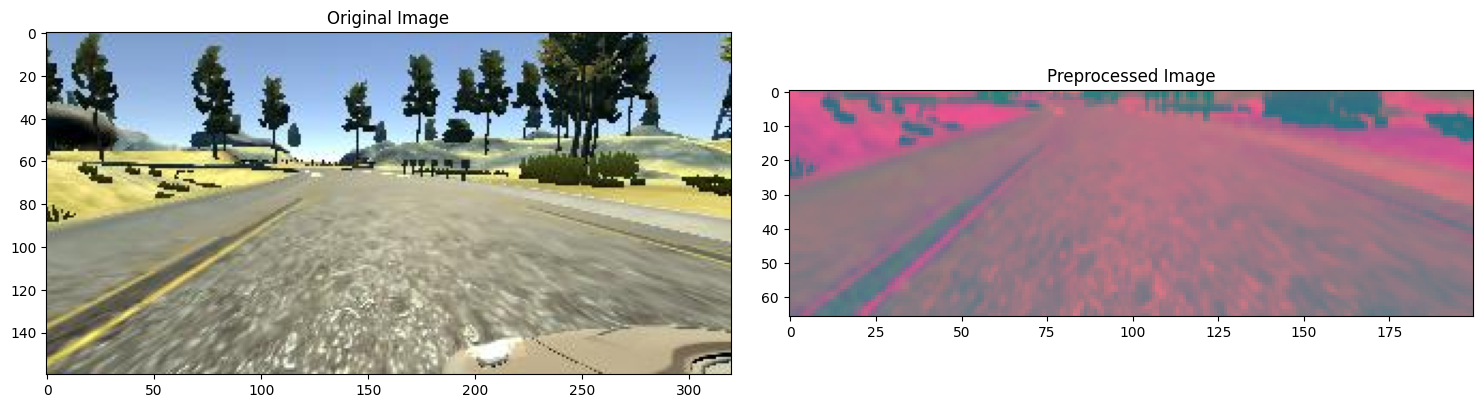

In [29]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

In [30]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

(66, 200, 3)


Text(0.5, 1.0, 'Validation Image')

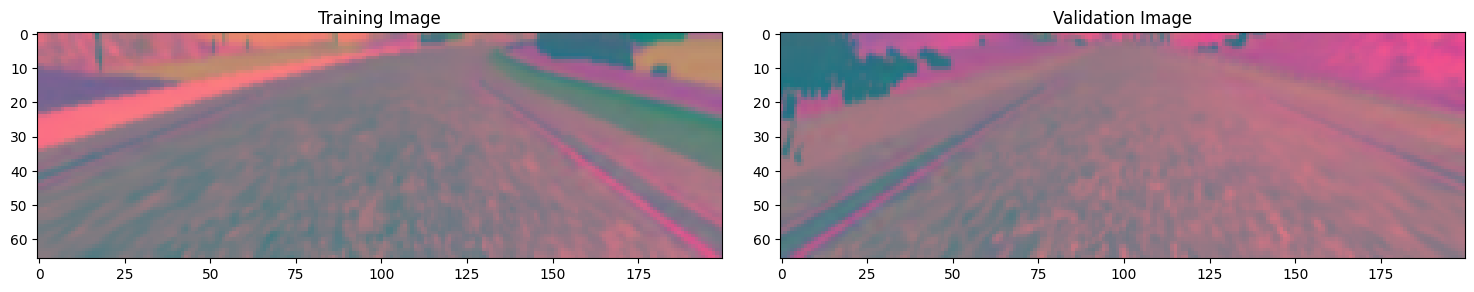

In [32]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

print(x_train_gen[0].shape)

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")